# MAP 568 Project

Maxime Vincent & Swann Chelly

In [1]:
import numpy as np

from constant import *
from scipy import *
from scipy import stats
from pylab import *     
from scipy.integrate import odeint # Module de résolution des équations différentielles
from progressbar import ProgressBar
import matplotlib.pyplot as plt

## Incertitudes en sortie

1) **Programmer la résolution du système (1-10).**

Dans le fichier constant nous définissons l'ensemble des constantes. La fonction `init_constant` de ce fichier renvoie un dictionnaire généré aléatoirement de constantes. 

In [2]:
## Résolution de l'équation différentielle. 

def equa_diff(syst,temps,variables, constants):
    
    """
    La résolution du système d'équation différentiel (1-10) se fait grace au module odeint de scipy.integrate.
    
    Paramètres :
    ------------
    
    syst : 
    
    temps : 
    
    Sorties : 
    ---------
    Ensemble des paramètres du système différentiel. 
    
    """
    
    if type(variables)!= dict:
        variables = dict(zip(variables_keys,variables))
        constants = dict(zip(constants_keys, constants))
    
    
    
    tau = constants['tau_0']*np.exp(-variables['mu']*max(temps-variables['N'],0))
    S = syst[0] 
    I_moins = syst[1] 
    I_plus = syst[2] 
    R_moins = syst[3] 
    R_plus_I = syst[4] 
    H = syst[5] 
    U = syst[6] 
    R_plus_H = syst[7] 
    D = syst[8] 
    D_R = syst[9]
    # Dérivées des variables
    DS = -tau*S*I_moins
    DI_moins = tau*S*I_moins-variables['lambda_1']*I_moins-(constants['gamma_IR']+constants['gamma_IH']+constants['gamma_IU'])*I_moins
    DI_plus = variables['lambda_1']*I_moins-(constants['gamma_IR']+constants['gamma_IH']+constants['gamma_IU'])*I_plus
    DR_moins = constants['gamma_IR']*I_moins
    DR_plus_I = constants['gamma_IR']*I_plus
    DH = constants['gamma_IH']*(I_moins + I_plus)-(constants['gamma_HR']+constants['gamma_HD']+constants['gamma_HU'])*H
    DU = constants['gamma_IU']*(I_moins + I_plus)+constants['gamma_HU']*H-(constants['gamma_UR'] + constants['gamma_UD'])*U
    DR_plus_H = constants['gamma_HR']*H+constants['gamma_UR']*U
    DD =constants['gamma_UD']*U+constants['gamma_HD']*H  
    DD_R = (variables['lambda_1']+constants['gamma_IH']+constants['gamma_IU'])*I_moins-D_R
    
    
    return([DS,DI_moins,DI_plus,DR_moins,DR_plus_I,DH,DU,DR_plus_H,DD,DD_R])


Text(0, 0.5, 'Nombre de personne en réanimation')

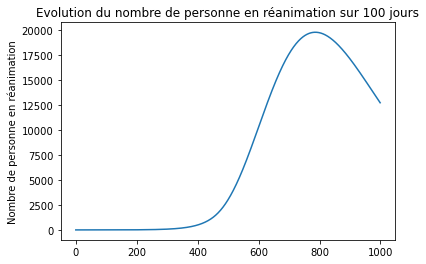

In [3]:
# Analyse des résultats

variables = init_variables()
constants = compute_constants(variables)


syst_CI=array([global_constants['S_0'],variables['I_moins_0'],0,0,0,0,0,0,0,0])
simulation=odeint(equa_diff,syst_CI,np.linspace(0,100,1000), args = (variables,constants))
plt.plot(simulation[:,6])
plt.title(f"Evolution du nombre de personne en réanimation sur {global_constants['T_MAX']} jours")
plt.ylabel("Nombre de personne en réanimation")



2) **Par échantillonnage Monte Carlo (en utilisant les lois des paramètres d'entrée de la table 1), donner :**
- la loi du nombre maximal de patients présents en soins intensifs (histogramme, moyenne, quantiles à 10% et 90%),
- la loi de la date du pic de l'épidémie.

In [4]:
## Implémentation de la méthode de Monte Carlo classique pour la résolution du système différentiel. 
M = 1000

def Monte_Carlo(M, methode):
    """
    Echantillonage de Monte Carlo 
    
    Paramètres : 
    ------------
    
    M : int, 
        Taille de l'échantillon. 
    
    Sorties : 
    ---------
    peak_value  : list,
        Nombre de cas en réanimation au pic de l'épidémie pour chaque simulation.
    peak_day    : list, 
        Jour du pic pour chaque simulation.
    pos         : list, 
        Nombre de cas au pic de l'épidémie pour chaque simulation.
    
    """
    
    print(f"Echantillonnage de Monte Carlo sur {M} simulations")
    peak_value,peak_day, pos = [],[], []
    pbar = ProgressBar()
    for i in pbar(range(M)):
        if methode == 'odeint':
            
            variables = init_variables(deltaT=global_constants['deltaT'],global_constants = global_constants)
            constants = compute_constants(variables)
            syst_CI=array([global_constants['S_0'],variables['I_moins_0'],0,0,0,0,0,0,0,0])
            simulation=odeint(equa_diff,syst_CI,constants['t'], args = (variables,constants))      
            peak_value.append(np.max(simulation[:,6]))
            peak_day.append(int(variables['t_0']np.argmax(list(simulation[:,6]))*global_constants['deltaT']))
            pos.append(np.max(simulation[:,1]))
        if methode == 'euler' :
            variables = init_variables(deltaT=global_constants['deltaT'],global_constants = global_constants)
            constants = compute_constants(variables)
            simulation = np.transpose(resolution_systeme(global_constants['deltaT'],constants, variables, set_size = global_constants['set_size']))
            #peak_value.append(np.max(simulation[6]))
            #peak_day.append(int(np.argmax(list(simulation[6]))*global_constants['deltaT']))
            #pos.append(np.max(simulation[1]))
            peak_value.append(np.max(simulation[:,6]))
            peak_day.append(int(np.argmax(list(simulation[:,6]))*global_constants['deltaT']))
            pos.append(np.max(simulation[:,1]))
        
    return (peak_value,peak_day,pos)

peak_value,peak_day,pos = Monte_Carlo(M, methode = 'odeint')

  0% (7 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:00:14

Echantillonnage de Monte Carlo sur 1000 simulations


100% (1000 of 1000) |####################| Elapsed Time: 0:00:15 Time:  0:00:15


La valeur moyenne du pic est de 29802.4 et appartient à l'intervalle de confiance à 95% suivant : [25724.44,33880.36] 
 Le quantile à 10% du pic de réanimation est : 33.73791972856378
 Le quantile à 90% du pic de réanimation est : 108371.69433968553


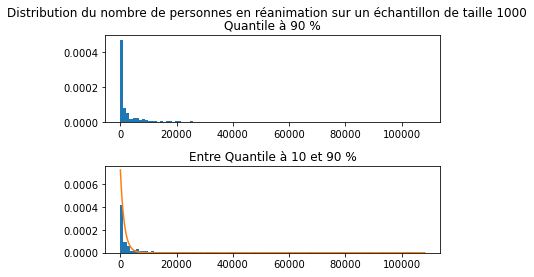

In [5]:
mean_value = np.mean(peak_value)
var_value  = np.var(peak_value)
q_10 = np.quantile(peak_value, 0.1, axis = None)
q_70 = np.quantile(peak_value, 0.7, axis = None)
q_90 = np.quantile(peak_value, 0.9, axis = None)
print(f"La valeur moyenne du pic est de {round(mean_value,2)} et appartient à l'intervalle de confiance à 95% suivant : [{max(0,round(mean_value-1.96*np.sqrt(var_value/M),2))},{round(mean_value+1.96*np.sqrt(var_value/M),2)}] ")
print(f" Le quantile à 10% du pic de réanimation est : {q_10}")
print(f" Le quantile à 90% du pic de réanimation est : {q_90}")

# Compte tenu de la valeur du quantile à 90% nous tronquons donc la liste par soucis de visibilité. 


fig, axs = plt.subplots(2)
fig.suptitle(f"Distribution du nombre de personnes en réanimation sur un échantillon de taille {M}")
axs[0].hist([value for value in peak_value if value < q_90], bins = 100, density = 1)
axs[0].set_title('Quantile à 90 %')
axs[1].hist([value for value in peak_value if (value > q_10 and value < q_90)], bins = 100, density = True)
axs[1].set_title('Entre Quantile à 10 et 90 %')
x=np.arange(0,max([value for value in peak_value if (value > q_10 and value < q_90)]), 0.01)
Moy = np.mean([value for value in peak_value if (value > q_10 and value < q_90)])
Median = np.median([value for value in peak_value if (value > q_10 and value < q_90)])
axs[1].plot(x,stats.expon.pdf(x, scale=Median), label="densité") 
plt.subplots_adjust(hspace=0.5)

En supposant que la distribution du nombre de cas en réanimation au pic de l'épidémie suis une loie exponentielle, nous pouvons donner son paramètre $\lambda = \frac{1}{\mathbb{\hat{E}}(X)}$ où $X$ correspond à la variable aléatoire liée au nombre de cas en réanimation au pic de l'épidémie. Nous la notrons ici `lbd`.


La valeur moyenne du pic est de 69.87 et appartient à l'intervalle de confiance à 95% suivant : [68.87,70.87] 
 Le quantile à 10% du pic de réanimation est : 49.900000000000006
 Le quantile à 90% du pic de réanimation est : 97.0


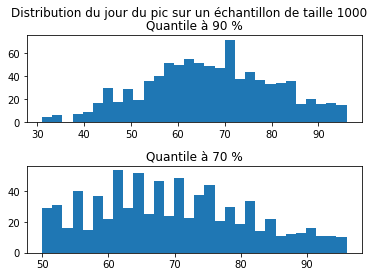

In [6]:
# Loi de la date de l'épidémie. 

mean_day = np.mean(peak_day)
var_day  = np.var(peak_day)
q_10_day = np.quantile(peak_day, 0.1, axis = None)
q_70_day = np.quantile(peak_day, 0.7, axis = None)
q_90_day = np.quantile(peak_day, 0.9, axis = None)
print(f"La valeur moyenne du pic est de {round(mean_day,2)} et appartient à l'intervalle de confiance à 95% suivant : [{max(0,round(mean_day-1.96*np.sqrt(var_day/M),2))},{round(mean_day+1.96*np.sqrt(var_day/M),2)}] ")
print(f" Le quantile à 10% du pic de réanimation est : {q_10_day}")
print(f" Le quantile à 90% du pic de réanimation est : {q_90_day}")

# Compte tenu de la valeur du quantile à 90% nous tronquons donc la liste par soucis de visibilité. 

fig, axs = plt.subplots(2)
fig.suptitle(f"Distribution du jour du pic sur un échantillon de taille {M}")
axs[0].hist([day for day in peak_day if day < q_90_day], bins = 30)
axs[0].set_title('Quantile à 90 %')
axs[1].hist([day for day in peak_day if (day > q_10_day and day < q_90_day)], bins = 30)
axs[1].set_title('Quantile à 70 %')
plt.subplots_adjust(hspace=0.5)

# Analyse de sensibilité qualitative : Criblage

## Criblage avec SALib

In [35]:
from SALib.analyze import morris
from SALib.sample import morris as sample_morris

In [43]:
problem = {
    'num_vars': 15,
    'names': ['p_a','p_IH','p_IU','p_HD','p_HU','p_UD','R_0','mu','lambda_1','t_0','N','N_I','N_H','N_U','I_moins_0'],
    'bounds': [[0.4,0.9],[0.05,0.2],[0.01,0.04],[0.1,0.2],[0.1,0.2],[0.2,0.4],[2.9,3.4],[0.01,0.08],[10**(-4),10**(-3)],[0,30],[30,50],
[8,12],[15,25],[10,20],[1,100]]
}


def Resolution(parametres):
    peak_value = np.zeros(len(parametres))
    peak_day = np.zeros(len(parametres))
    global_constants['deltaT']=1
    for i, X in enumerate(parametres):
    
        if type(X)!= dict:
            variables = dict(zip(variables_keys,X))
            #constants = dict(zip(constants_keys, constants))
        else : 
            variables = X
        constants = compute_constants(variables)   
        syst_CI=array([global_constants['S_0'],variables['I_moins_0'],0,0,0,0,0,0,0,0])
        simulation=odeint(equa_diff,syst_CI,constants['t'], args = (variables,constants))
        #simulation = np.transpose(resolution_systeme(global_constants['deltaT'],constants, variables, set_size = global_constants['set_size']))
        peak_value[i]=np.max(simulation[:,6])
        peak_day[i]=int(variables['t_0']+ np.argmax(list(simulation[:,6]))*global_constants['deltaT'])
    return(peak_value, peak_day)



In [44]:
X = sample_morris.sample(problem, 100, num_levels=4)
peak_value, peak_day = Resolution(X)
Smorris_value = morris.analyze(problem, X, peak_value, conf_level=0.95,print_to_console=True, num_levels=4)
Smorris_day = morris.analyze(problem, X, peak_day, conf_level=0.95,print_to_console=True, num_levels=4)

Parameter                         Mu_Star         Mu    Mu_Star_Conf      Sigma
p_a                             46750.060 -46750.060       21247.187 105610.278
p_IH                            11871.076  11871.076        5824.068  29597.451
p_IU                            27024.801  27024.801       12518.215  63977.890
p_HD                                0.001      0.000           0.000      0.002
p_HU                             4553.960   4553.960        2193.620  11068.300
p_UD                                0.001      0.000           0.000      0.002
R_0                             29124.099  29124.099       12418.677  60928.387
mu                              40490.415 -40490.415       21312.478 102583.633
lambda_1                         1545.056   1545.056         653.682   3752.819
t_0                             63063.273 -63063.273       27368.810 135020.308
N                               34659.853  34659.853       14271.706  67829.264
N_I                             90917.16

# Analyse de sensibilité quantitative : Sobol

In [45]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
from pylab import *
from scipy.integrate import odeint

In [46]:
param_values = saltelli.sample(problem, 100, calc_second_order=True)
peak_value, peak_day = Resolution(param_values)
Si_peak_value = sobol.analyze(problem, peak_value, print_to_console=True)
Si_peak_day = sobol.analyze(problem, peak_day, print_to_console=True)

Group S1 S1_conf ST ST_conf
p_a 0.027918 0.048533 0.129421 0.219408
p_IH -0.008529 0.014932 0.008405 0.016569
p_IU -0.010097 0.049486 0.065597 0.097074
p_HD 0.000000 0.000000 0.000000 0.000000
p_HU 0.005554 0.017273 0.001488 0.002057
p_UD 0.000000 0.000000 0.000000 0.000000
R_0 -0.023548 0.085600 0.139003 0.249314
mu -0.000449 0.104058 0.269200 0.361631
lambda_1 -0.000634 0.002694 0.000140 0.000202
t_0 0.147798 0.119250 0.158994 0.215449
N 0.131689 0.185659 0.432268 0.613999
N_I 0.091632 0.133395 0.325026 0.443813
N_H -0.000573 0.002045 0.000278 0.000471
N_U 0.005310 0.011936 0.003371 0.005908
I_moins_0 -0.010444 0.027820 0.030367 0.060753

Group_1 Group_2 S2 S2_conf
p_a p_IH -0.023805 0.072624
p_a p_IU -0.026263 0.071268
p_a p_HD -0.026182 0.073939
p_a p_HU -0.027239 0.076680
p_a p_UD -0.026182 0.073939
p_a R_0 -0.028030 0.069353
p_a mu -0.016067 0.071987
p_a lambda_1 -0.026048 0.073588
p_a t_0 -0.048656 0.060943
p_a N -0.009165 0.114339
p_a N_I -0.012859 0.110643
p_a N_H -0.025749 0.

In [ ]:
peak_value

# QUESTION 5

In [14]:
global_constants['deltaT']=1
global_constants['set_size'] =  int(global_constants['T_MAX']/global_constants['deltaT'])
variables = init_variables(deltaT=global_constants['deltaT'],global_constants = global_constants)
constants = compute_constants(variables,global_constants= global_constants)
def Resolution_selon_temps(parametres):
    H,U,D,R_plus_H = [],[],[],[]
    #peak_day = np.zeros(len(parametres))
    #global_constants['deltaT']=1
    for i, X in enumerate(parametres):
        
        #print(i)
        if type(X)!= dict:
            variables = dict(zip(variables_keys,X))
            #constants = dict(zip(constants_keys, constants))
        else : 
            variables = X
        constants = compute_constants(variables)   
        syst_CI=array([global_constants['S_0'],variables['I_moins_0'],0,0,0,0,0,0,0,0])
        simulation=odeint(equa_diff,syst_CI,constants['t'], args = (variables,constants))
        #simulation = np.transpose(resolution_systeme_bis(global_constants['deltaT'],constants, variables, set_size = global_constants['set_size']))
        H.append(simulation[:,5])
        U.append(simulation[:,6])
        R_plus_H.append(simulation[:,7])
        D.append(simulation[:,8])
    return(H,U,R_plus_H,D)

In [15]:
param_values = saltelli.sample(problem, 100, calc_second_order=True)
H,U,D,R_plus_H  = Resolution_selon_temps(param_values)
H = np.array(H)
U = np.array(U)
R_plus_H = np.array(R_plus_H)
D = np.array(D)

In [16]:
var_H = []
var_U = []
var_R_plus_H = []
var_D = []
var_HT = []
var_UT = []
var_R_plus_HT = []
var_DT = []
pbar = ProgressBar()
for i in pbar(range(U.shape[1])):
    h = H[:,i]
    u = U[:,i]
    r_plus_h = R_plus_H[:,i]
    d = D[:,i]
    Si_H = sobol.analyze(problem,h)
    Si_U = sobol.analyze(problem,u)
    Si_R_plus_H = sobol.analyze(problem,r_plus_h)
    Si_D = sobol.analyze(problem,d)
    var_H.append(Si_H['S1'])
    var_U.append(Si_U['S1'])
    var_R_plus_H.append(Si_R_plus_H['S1'])
    var_D.append(Si_D['S1'])
    var_HT.append(Si_H['ST'])
    var_UT.append(Si_U['ST'])
    var_R_plus_HT.append(Si_R_plus_H['ST'])
    var_DT.append(Si_D['ST'])
    
    
VAR = [np.array(var_H), np.array(var_U), np.array(var_R_plus_H), np.array(var_D), np.array(var_HT), np.array(var_UT), np.array(var_R_plus_HT), np.array(var_DT)]
var = np.array(var)

N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/max/opt/anaconda3/lib/python3.8/site-packages/SALib/analyze/sobol.py:87: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean()) / Y.std()
100% (100 of 100) |######################| Elapsed Time: 0:01:03 Time:  0:01:03


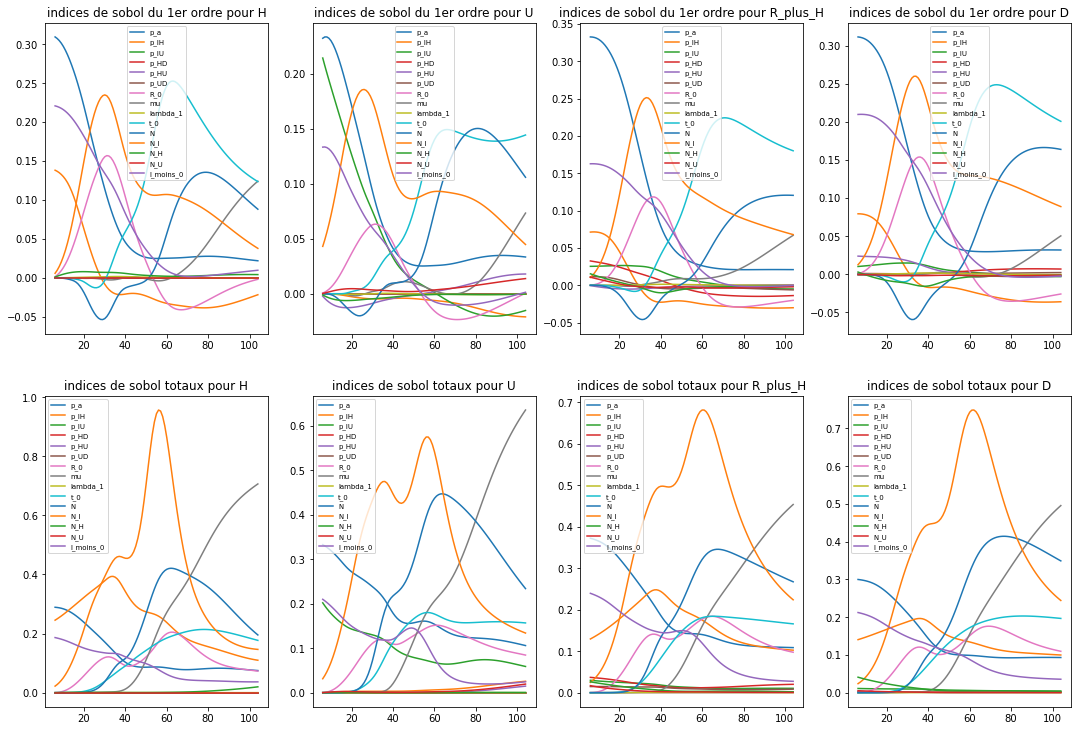

In [17]:
title = ['H','U', 'R_plus_H', 'D']
indices = ['du 1er ordre', 'totaux']
for j in range(len(VAR)):
    plt.subplot(2, 4, j+1)
    for i in range(len(VAR[0][0])):
        #plt.plot(constants['t'],VAR[j][:,i],label=problem['names'][i])
        plt.plot(constants['t'][::int(1/global_constants['deltaT'])],VAR[j][:,i],label=problem['names'][i])
    plt.subplots_adjust(left=None, bottom=None, right=2.5, top=2.5, wspace=None, hspace=None)
    plt.legend(loc='best', fontsize='x-small')
    plt.title('indices de sobol ' + indices[j//4] + ' pour ' + title[j%4])
plt.show()

In [53]:
print(var[:,0][:10])
print(var[:,1][:10])

[       nan 0.31069288 0.31057838 0.31045884 0.31033418 0.31020434
 0.31006922 0.30992877 0.3097829  0.30963153]
[       nan 0.13918926 0.13910468 0.13901701 0.1389262  0.13883219
 0.13873493 0.13863437 0.13853044 0.13842311]


# Calibration

In [48]:
import pandas as pd
import matplotlib.dates as mdates
from matplotlib import ticker

In [49]:

contamination = pd.read_csv('data_per_day.csv', sep = ';')
contamination.columns = [jour,'detecte']
contamination[jour] = pd.to_datetime(contamination[jour],infer_datetime_format = True)
contamination = contamination[contamination[jour]<= '2020-05-11']
contamination['detecte'] = contamination['detecte'].diff(periods = 1)

 
hosp          = pd.read_csv('donnees_hospitalieres.csv', ';')
hosp[jour]    = pd.to_datetime(hosp[jour])
hosp          = hosp.groupby(jour).agg('sum').reset_index(False)[[jour,'hosp','rea','rad','dc']]
big_table     = hosp.merge(contamination, left_on= jour, right_on = jour)
big_table     = big_table[big_table[jour]<= '2020-05-11']
big_table.head()   

,jour,hosp,rea,rad,dc,detecte
0,2020-03-18,5905,1535,1627,435,1404.0
1,2020-03-19,7961,1975,2322,642,1861.0
2,2020-03-20,10272,2564,3128,890,1617.0
3,2020-03-21,11599,2872,3580,1041,1847.0
4,2020-03-22,13675,3311,4188,1251,1559.0


Text(0.5, 1.0, 'Spread of the epidemic')

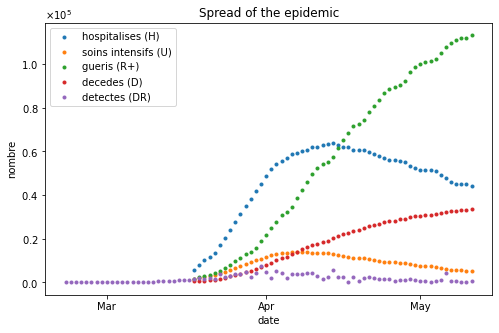

In [50]:
columns = ['hosp','rea','rad','dc']
titles  = {'hosp': 'hospitalises (H)', 'rea': 'soins intensifs (U)', 'dc' : 'decedes (D)', 'detecte' : 'detectes (DR)', 'rad' : 'gueris (R+)'}

fig, axs = plt.subplots(figsize = (8,5), nrows = 1, ncols = 1)
for i,col in enumerate(columns) : 
    axs.scatter(big_table[jour],big_table[col],marker = '.', label = titles[col])
axs.scatter(contamination[jour],contamination['detecte'], marker = '.', label = titles['detecte'])
axs.legend()
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)


formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))
axs.yaxis.set_major_formatter(formatter) 
axs.set_ylabel('nombre')
axs.set_xlabel('date')
axs.format_xdata = mdates.DateFormatter('%Y-%m-%d')
axs.set_title('Spread of the epidemic')

# Calibration déterministe

Pour répondre à cette question, nous lançons la fonction `minimize` de scipy.optimize 100 fois et nous gardons uniquement le 15-uplets de valeurs qui minimise le plus fortement la fonction objectif.

Une telle démarche a nécessairement un coût de calcul assez fort et nous sauvons donc le tout dans un excel fournit avec le jupyter. Afin de pouvoir générer les variables veuillez mettre `generate_variables` à la valeur `True`. Autrement, les variables seront importées depuis le fichier CSV en question. 

In [51]:
from scipy.optimize import minimize
generate_variables = False

In [52]:
# Table pre-processing
contamination = contamination[('2020-02-25' <= contamination[jour])& (contamination[jour]<= '2020-03-31')]
big_table     = big_table[big_table[jour]<= '2020-03-31']
sigmas        = [1,1,1,1,1]

In [53]:

def Epsilon(variables,constants,contamination = contamination,big_table=big_table,global_constants=global_constants, sigmas = sigmas,n_DR=n_DR,n_H=n_H):
    """
    parameters will be a dictionnary similar to the one resulting from init_constant    
    """
    
    syst_CI=array([global_constants['S_0'],variables[-1],0,0,0,0,0,0,0,0])
    simulation=odeint(equa_diff,syst_CI,constants[-2],args = (variables,constants))
           
    
    DR = ((simulation[n_DR:,-1]-contamination['detecte'].to_numpy())/np.sqrt(simulation[n_DR:,-1])/sigmas[0])**2
    
    H  = ((simulation[n_H:,5]-big_table['hosp'].to_numpy())/np.sqrt(simulation[n_H:,5])/sigmas[1])**2
    U  = ((simulation[n_H:,6]-big_table['rea'].to_numpy())/np.sqrt(simulation[n_H:,6])/sigmas[2])**2
    D  = ((simulation[n_H:,8]-big_table['dc'].to_numpy())/np.sqrt(simulation[n_H:,8])/sigmas[3])**2
    R  = ((simulation[n_H:,7]-big_table['rad'].to_numpy())/np.sqrt(simulation[n_H:,7])/sigmas[4])**2
    return np.sum(DR) + np.sum(H+U+D+R)



In [54]:


def q_7_function():
    """
    This function compute the minimization routine one time and return the 15-uplet and the value of the objectiv function.    
    """
    variables = init_variables(T_MAX = 66)
    constants = compute_constants(variables, global_constants = global_constants)
    variables = list(variables.values())
    constants = list(constants.values())

    res = minimize(Epsilon,x0 = variables,bounds = bound, args = (constants))
    optimal_variables = dict(zip(variables_keys,res.x))
    return optimal_variables,res.fun

if generate_variables :     
    all_results = []
    all_variables = []
    pbar = ProgressBar()

    for i in pbar(range(100)):
        optimal_variables, res = q_7_function()
        all_results.append(res)
        all_variables.append(optimal_variables)
    
    best_variables = all_variables[np.argmin(all_results)]
    with open('best_variables_q7_odeint.csv', 'w') as f:
        f.write("%s,%s\n"%('variables','values'))
        for key in best_variables.keys():
            f.write("%s,%s\n"%(key,best_variables[key]))
    
    
else : 
    best_variables = pd.read_csv('best_variables_q7_odeint.csv', ',')
    best_variables = best_variables['values'].to_numpy()
    best_variables = dict(zip(variables_keys,best_variables))
    

In [55]:

constants  = compute_constants(best_variables)
syst_CI    = array([global_constants['S_0'],best_variables['I_moins_0'],0,0,0,0,0,0,0,0])
simulation = odeint(equa_diff,syst_CI,constants['t'], args = (best_variables,constants))[::int(1/global_constants['deltaT'])]


Text(0.5, 1.0, 'Spread of the epidemic')

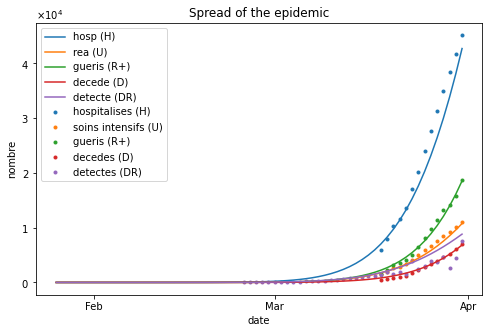

In [56]:
fig, axs = plt.subplots(figsize = (8,5), nrows = 1, ncols = 1)
columns  = [5,6,7,8,9]
titles   = {'5':'hosp (H)','6': 'rea (U)','8':'decede (D)', '9':'detecte (DR)','7': 'gueris (R+)'}
time     = pd.date_range(start =  '2020-01-26', end = '2020-03-31', freq = 'D')

for i,col in enumerate(columns) : 
    axs.plot(time,simulation[:66,col], label = titles[f"{col}"])
axs.legend()
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)


formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))
axs.yaxis.set_major_formatter(formatter) 
axs.set_ylabel('nombre')
axs.set_xlabel('date')
axs.format_xdata = mdates.DateFormatter('%Y-%m-%d')
axs.set_title('Spread of the epidemic')



columns = ['hosp','rea','rad','dc']
titles  = {'hosp': 'hospitalises (H)', 'rea': 'soins intensifs (U)', 'dc' : 'decedes (D)', 'detecte' : 'detectes (DR)', 'rad' : 'gueris (R+)'}

for i,col in enumerate(columns) : 
    axs.scatter(big_table[jour],big_table[col],marker = '.', label = titles[col])
axs.scatter(contamination[jour],contamination['detecte'], marker = '.', label = titles['detecte'])
axs.legend()
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)


formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))
axs.yaxis.set_major_formatter(formatter) 
axs.set_ylabel('nombre')
axs.set_xlabel('date')
axs.format_xdata = mdates.DateFormatter('%Y-%m-%d')
axs.set_title('Spread of the epidemic')

8) **Donnez les valeurs de $\sigma_C$ pour $C$ dans $\{H,U,D,R\}$**

L'énoncé nous dit que : 

$\begin{equation}
p(data|x,\sigma)=(2\pi)^{-\frac{n_{DR}}{2}-2n_{H}}\sigma_{DR}^{-n_{DR}}\sigma_{H}^{-n_{H}}\sigma_{U}^{-n_{H}}\sigma_{D}^{-n_{H}}\sigma_{R}^{-n_{H}}\times e^{-\frac{1}{2}\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{\sigma_{DR}^{2}}-\frac{1}{2}\sum_{i=1}^{n_{H}}\frac{f_{H}(x,s_{i})2}{\sigma_{H}^{2}}+\frac{f_{U}(x,s_{i})^{2}}{\sigma_{U}^{2}}+\frac{f_{D}(x,s_{i})^{2}}{\sigma_{D}^{2}}+\frac{f_{R}(x,s_{i})^{2}}{\sigma_{R}^{2}}}
\end{equation}$

Que l'on peut réécrire de la manière suivante afin de d'utiliser une optimisation sous log-vraisemblance par la suite : 

$\begin{equation}
p(data|x,\sigma)=(2\pi)^{-\frac{n_{DR}}{2}-2n_{H}}\sigma_{H}^{-n_{H}}\sigma_{U}^{-n_{H}}\sigma_{D}^{-n_{H}}\sigma_{R}^{-n_{H}}\times e^{-n_{DR}ln(\sigma_{DR})-\frac{1}{2}\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{\sigma_{DR}^{2}}-\frac{1}{2}\sum_{i=1}^{n_{H}}\frac{f_{H}(x,s_{i})2}{\sigma_{H}^{2}}+\frac{f_{U}(x,s_{i})^{2}}{\sigma_{U}^{2}}+\frac{f_{D}(x,s_{i})^{2}}{\sigma_{D}^{2}}+\frac{f_{R}(x,s_{i})^{2}}{\sigma_{R}^{2}}}
\end{equation}$


On atteint un optimum pour l'expression suivante quand toutes les compostantes du gradient sont nulles. En raisonnant pour $\sigma_{DR}$ on a : 

$\begin{align}
\frac{\partial}{\sigma_{DR}}p(data|x,\sigma)&=(2\pi)^{-\frac{n_{DR}}{2}-2n_{H}}\sigma_{H}^{-n_{H}}\sigma_{U}^{-n_{H}}\sigma_{D}^{-n_{H}}\sigma_{R}^{-n_{H}}\times(-\frac{n_{DR}}{\sigma_{DR}}+\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{\sigma_{DR}^{3}})e^{-n_{DR}ln(\sigma_{DR})-\frac{1}{2}\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{\sigma_{DR}^{2}}-\frac{1}{2}\sum_{i=1}^{n_{H}}\frac{f_{H}(x,s_{i})2}{\sigma_{H}^{2}}+\frac{f_{U}(x,s_{i})^{2}}{\sigma_{U}^{2}}+\frac{f_{D}(x,s_{i})^{2}}{\sigma_{D}^{2}}+\frac{f_{R}(x,s_{i})^{2}}{\sigma_{R}^{2}}}\\
&=0
\end{align}$
Ce qui revient à écrire que : 


$\begin{align}
& \ \frac{n_{DR}}{\sigma_{DR}}=\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{\sigma_{DR}^{3}}\\
\Leftrightarrow &  \ \sigma_{DR}^{2}=\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{n_{DR}}
\end{align}$

En raisonnant de même pour les autres sigmas, il vient que :

$\sigma_{C}^{2}=\sum_{i=1}^{n_{H}}\frac{f_{C}(x,s_{i})^{2}}{n_{H}}$



9) **Donner une expression implicite de la loi a posteriori $p(x|data)$ des paramètres x.**

Le théorème de Bayes nous donne que : $p(x|data) \propto p(data|x)p_0(x)$.

Pour l'approche plug-in, on fixe les valeurs de sigma tel que définis à la question 8. Dans ce cas, on a : 

$\begin{equation}
p(x|data)=p(data|x)p_0(x)
\end{equation}$

Dans le cadre de l'approche full-bayésienne comme on a : $\pi(\sigma_C)=(\sigma_C)^{-1}$ pour $C$ dans $\{H,U,D,R\}$ alors on peut écrire que : $\begin{align}
p(x|data) &\propto \int_{\sigma}p(x,\sigma|data)d\sigma\\
&\propto \int_{\sigma}p(data|x,\sigma)p(\sigma)p_0(x)d\sigma
\end{align}$

En utilisant les expressions de chacun des $\sigma$ on peut développer l'intégrale et donner une expression implicite de cette densité. 


10) **Dans le cas plug-in, puis dans le cas full-bayésien, comparer les lois a priori et a posteriori uni-dimensionnelles de chacun des paramètres (histogramme,moyenne, variance). Estimer la matrice de corrélation a posteriori des paramètres. Quels sont les paramètres pour lesquels l'incertitude a été fortement réduite ou au contraire très peu réduite ?**


Nous connaissons les lois à postériori à une constante multiplicative près. De ce fait nous souhaitons donc simuler la distribution de $p(x|data)$ en utilisant un algorithme de Metropolis Hasting. 

A partir d'un point $X_0$, nous construisons la chaîne de Markov de la façon suivante : 

- On propose un déplacement vers $\tilde{X}_{n+1}$ selon la loi $q(X_n,\sigma^2I)$ supposée gaussienne. On améliorera la matrice de covariance de cette loi durant la procédure de burn-in. 

- On accepte le déplacement avec la probabilité $a(X_n,\tilde{X}_{n+1})$. La fonction $a$ est définie comme suit : 

\begin{align}
a(X_n,\tilde{X}_{n+1}) &= min\{\frac{p(\tilde{X}_{n+1}|data)Q(X_n,\tilde{X}_{n+1})}{p(X_n|data)Q(\tilde{X}_{n+1},X_n)},1\}\\
&= min\{\frac{p(data|\tilde{X}_{n+1})Q(X_n,\tilde{X}_{n+1})}{p(data|X_n)Q(\tilde{X}_{n+1},X_n)},1\}
\end{align}

La difficulté que nous rencontrons ici est que les paramètres doivent évoluer dans un certain intervalle. Par exemple, la proportion de personne passant d'un compartiment à l'autre (ex : $p_a$) est dans $[0,1]$. Tous les paramètres doivent être positifs. Afin de pouvoir jouer avec ces disparités, nous avons tout d'abord essayé de tirer ces paramètres selon des lois lognormales ou bêta. Néanmoins nous ne maîtrisions pas bien ces lois. Nous proposons ci-dessous un pseudo-algorithme décrivant notre procédure. 

1. Approche plug-in 

Le dictionnaire `F` contient les lois que l'on va utiliser pour calculer les paramètres. Dans cette approche nous prenons uniquement des lois normales. Le dictionnaire `F_parameters` contient les paramètres initiaux de ces lois. Il est mis à jour tout au long de la phase de burning. 

- Tirage de $X\_$ selon l'ensemble des lois de `F` (fonction `move`) et la position actuelle de la chaîne $X$
- On vérifie si le déplacement est acceptable (fonction `not_accepted_move`) : les paramètres sont-ils dans le bon intervalle. Si $X\_$ n'est pas accepté on choisit $X$ comme nouvelle position de la chaîne. 
- On calcule $a$ selon la formule de MH. 
- Pendant la phase de burnin on regroupe dans la variable `accepted_history` le nombre de déplacements acceptés depuis le dernier ajustement des paramètres.





In [57]:
from scipy.stats import lognorm
from scipy.stats import norm
from scipy.stats import uniform

np.random.seed(4)

In [58]:



F = {'p_a': 'norm',
    'p_IH': 'norm',
    'p_IU': 'norm',
    'p_HD': 'norm',
    'p_HU': 'norm',
    'p_UD': 'norm',
    'N_I' : 'norm',
    'N_H' : 'norm',
    'N_U' : 'norm',
    'R_0' : 'norm',
    'mu'  : 'norm',
    'N'   : 'norm',
    't_0'   : 'norm',
    'I_moins_0' : 'norm',
    'lambda_1' : 'norm'
}



F_parameters = {'p_a': {'loc':0.65,'scale':0.1},
    'p_IH': {'loc':0.125,'scale':0.1},
    'p_IU': {'loc':0.025,'scale':0.1},
    'p_HD': {'loc':0.15,'scale':0.1},
    'p_HU': {'loc':0.15,'scale':0.1},
    'p_UD': {'loc':0.3,'scale':0.1},
    'N_I' : {'loc':10,'scale':1},
    'N_H' : {'loc':20,'scale':1},
    'N_U' : {'loc':15,'scale':1},
    'R_0' : {'loc':3.15,'scale':0.1},
    'mu'  : {'loc':0.05,'scale':0.01},
    'N'   : {'loc':40,'scale':1},
    't_0' : {'loc':15, 'scale':1},
    'I_moins_0' : {'loc':50,'scale':1},
    'lambda_1' : {'loc':0.5*10**(-4),'scale':10**(-5)}
}


print(F_parameters)


{'p_a': {'loc': 0.65, 'scale': 0.1}, 'p_IH': {'loc': 0.125, 'scale': 0.1}, 'p_IU': {'loc': 0.025, 'scale': 0.1}, 'p_HD': {'loc': 0.15, 'scale': 0.1}, 'p_HU': {'loc': 0.15, 'scale': 0.1}, 'p_UD': {'loc': 0.3, 'scale': 0.1}, 'N_I': {'loc': 10, 'scale': 1}, 'N_H': {'loc': 20, 'scale': 1}, 'N_U': {'loc': 15, 'scale': 1}, 'R_0': {'loc': 3.15, 'scale': 0.1}, 'mu': {'loc': 0.05, 'scale': 0.01}, 'N': {'loc': 40, 'scale': 1}, 't_0': {'loc': 15, 'scale': 1}, 'I_moins_0': {'loc': 50, 'scale': 1}, 'lambda_1': {'loc': 5e-05, 'scale': 1e-05}}


In [60]:

def not_accepted_move(X_):
    
    variables = dict(zip(variables_keys,X_))
    for key,value in variables.items():
        if key in ['p_a','p_IH','p_IU','p_HD','p_HU','p_UD'] and not 0<=value<=1 :
            return True 
        if key in ['N_I','N_H','N_U','R_0','mu','N','t_0','I_moins_0','lambda_1'] and value < 0 :
            return True
        if key == 'I_moins_0' and value < 1 : 
            return True
    
    return False
        
    

def move(X,F_current_parameters):
    """
    Generate a possible movement for our scale
    """
    variables = dict(zip(variables_keys,X))
    X_ = []
    for key,values in variables.items() :
        f = F[key]
        if f == 'lognorm':
            x_ = lognorm.rvs(s = F_current_parameters[key]['s'], scale = values)
        if f == 'norm'   : 
            x_ = norm.rvs(loc = values, scale = F_current_parameters[key]['scale'] )
        if f == 'uniform' : 
            
            if F_parameters[key]['constraint']=='one':
                if values-F_current_parameters[key]['scale']/2 < F_parameters[key]['low'] :
                    F_current_parameters[key]['scale'] = 2*(values-F_parameters[key]['low'])
                    
            if F_parameters[key]['constraint']=='two':
                if values-F_current_parameters[key]['scale']/2 < F_parameters[key]['low'] or values+F_current_parameters[key]['scale']/2 > F_parameters[key]['high']:
                    F_current_parameters[key]['scale'] = min(2*(values-F_parameters[key]['low']),2*(F_parameters[key]['high']-values))
                    print('two',min(2*(values-F_parameters[key]['low']),2*(F_parameters[key]['high']-values)))
            x_ = uniform.rvs(loc = values - F_current_parameters[key]['scale']/2, scale = F_current_parameters[key]['scale'])
            
        if f == 'beta' :
            x_ = beta.rvs(loc = F_current_parameters[key]['loc'], scale = F_current_parameters[key]['scale'], a = 5, b = 5)
        X_.append(x_)
    return X_


def Q(X,X_,F_current_parameters):
    """
    Give the propability of the transition
    """
    probs = []
    
    variables  = dict(zip(variables_keys,X))
    variables_ = dict(zip(variables_keys,X_))  
    for key in variables_keys : 
        f = F[key]
        if f == 'lognorm':
            prob = lognorm.pdf(variables[key], s = variables_[key], scale = F_current_parameters[key]['scale'])
        if f == 'norm'   : 
            prob = norm.pdf(variables[key], loc = variables_[key], scale = F_current_parameters[key]['scale'])
        if f == 'uniform':
            prob = uniform.pdf(variables[key], loc = variables_[key] - F_current_parameters[key]['scale']/2 ,scale = F_current_parameters[key]['scale'] )
        if f == 'beta' : 
            prob = beta.pdf(variables[key], loc = variables_[key], scale = F_current_parameters[key]['scale'], a = 5 , b = 5)
        
        probs.append(prob)

        
    probs = np.array(probs)
    
    return np.prod(probs)

def a_plug_in(X,X_,sigmas,F_current_parameters):
    """
    Given a former position X and a new position X_, return the new position
    """
    if not_accepted_move(X_):
        #print('rejected')
        return 0
    ratio = plug_in(X,X_,sigmas)*Q(X,X_,F_current_parameters)/Q(X_,X,F_current_parameters)
    minimum = min(ratio,1)
   
    U     = np.random.uniform()
    if U> minimum : 
        return 0
    else :
        return 1
    
def Metropolis_Hasting_plug_in(X,F_parameters,n= 100000):
    """
    Given a random point X, we return a sample of Metroplis Hasting of size n. 
    """
    
    X = (list(X.values()))
    chain = [X]
    
    burn_in = n//10
    burn_in_period = 100
    
    thining_period = burn_in_period
    
    acceptation_history = np.zeros(burn_in_period)
    sigmas = compute_sigmas()
    pbar   = ProgressBar()
    for i in pbar(range(n)):
        X  = chain[-1]
        X_ = move(X,F_parameters)
        test = a_plug_in(X,X_,sigmas,F_parameters)
        
        if 1 < i < burn_in : 
        
            if test == 1 :             
                chain.append(X_)
            acceptation_history[i%burn_in_period] = test        
        
            if i % burn_in_period == 0 :
                rate = np.mean(acceptation_history)
                if rate < 0.25 : 
                    update_F('down')
                    #print('down',rate)
                if rate > 0.50 : 
                    update_F('up')
                    #print('up',rate)
                acceptation_history = np.zeros(burn_in_period)
        if i == burn_in : 
            
            print('start thining')
            chain = [chain[-1]]
        
        if i >= burn_in:     
            if i % thining_period == 0:
                if test == 1 : 
                    chain.append(X_)          
    
    return chain

def update_F(variation,F = F, F_parameters = F_parameters):
    
    for key in F_parameters.keys() : 
        if F[key] == 'lognormal':
            if variation == 'up' : 
                F_parameters[key]['s']*= 1.1
            if variation == 'down' :
                F_parameters[key]['s']*= 0.9
        if F[key] == 'norm':
            if variation == 'up':
                F_parameters[key]['scale']*= 1.1
            if variation == 'down':
                F_parameters[key]['scale']*= 0.9
        if F[key] == 'uniform':
            if variation == 'up':
                F_parameters[key]['scale']*= 1.1
            if variation == 'down':
                F_parameters[key]['scale']*= 0.9
        if F[key] == 'beta':
            if variation == 'up':
                F_parameters[key]['scale']*= 1.1
            if variation == 'down':
                F_parameters[key]['scale']*= 0.9
        
            
def plug_in(X,X_,sigmas):
    
    """
    Given the set of best variables, return the plug in probability according to the data.
    """
    variables  = dict(zip(variables_keys,X))
    variables_ = dict(zip(variables_keys,X_))
    constants  = compute_constants(variables)
    constants_  = compute_constants(variables_)
   
    constants  = list(constants.values())
    constants_ = list(constants_.values())
    result     = (Epsilon(X_,constants,sigmas = sigmas))/(Epsilon(X,constants,sigmas = sigmas))
  
        
    return np.exp(result)

def compute_sigmas(best_variables = best_variables,n_DR=n_DR,n_H=n_H,contamination = contamination,big_table=big_table):
    
    constants  = compute_constants(best_variables)
    syst_CI    = array([global_constants['S_0'],best_variables['I_moins_0'],0,0,0,0,0,0,0,0])
    simulation = odeint(equa_diff,syst_CI,constants['t'], args = (best_variables,constants))
    
    
    sigma_DR = np.sqrt(np.mean(((simulation[n_DR:,-1]-contamination['detecte'].to_numpy())/np.sqrt(simulation[n_DR:,-1]))**2))
    
    sigma_H  = np.sqrt(np.mean(((simulation[n_H:,5]-big_table['hosp'].to_numpy())/np.sqrt(simulation[n_H:,5]))**2))
    sigma_U  = np.sqrt(np.mean(((simulation[n_H:,6]-big_table['rea'].to_numpy())/np.sqrt(simulation[n_H:,6]))**2))
    sigma_D  = np.sqrt(np.mean(((simulation[n_H:,8]-big_table['dc'].to_numpy())/np.sqrt(simulation[n_H:,8]))**2))
    sigma_R  = np.sqrt(np.mean(((simulation[n_H:,7]-big_table['rad'].to_numpy())/np.sqrt(simulation[n_H:,7]))**2))
    
    sigmas = [sigma_DR,sigma_H,sigma_U,sigma_D,sigma_R]
    return sigmas

variables = init_variables(T_MAX = 66)

chain = Metropolis_Hasting_plug_in(variables, F_parameters)
    

  0% (80 of 100000) |                    | Elapsed Time: 0:00:01 ETA:   0:38:55<ipython-input-53-3d835b79e529>:15: RuntimeWarning: invalid value encountered in sqrt
  R  = ((simulation[n_H:,7]-big_table['rad'].to_numpy())/np.sqrt(simulation[n_H:,7])/sigmas[4])**2
  0% (96 of 100000) |                    | Elapsed Time: 0:00:02 ETA:   0:38:08<ipython-input-53-3d835b79e529>:10: RuntimeWarning: invalid value encountered in sqrt
  DR = ((simulation[n_DR:,-1]-contamination['detecte'].to_numpy())/np.sqrt(simulation[n_DR:,-1])/sigmas[0])**2
  7% (7102 of 100000) |#                 | Elapsed Time: 0:01:21 ETA:   0:13:26<ipython-input-60-44b7558a164c>:176: RuntimeWarning: overflow encountered in exp
  return np.exp(result)
 10% (10018 of 100000) |#                | Elapsed Time: 0:01:49 ETA:   0:16:47

start thining


100% (100000 of 100000) |################| Elapsed Time: 0:15:16 Time:  0:15:16


In [ ]:
chain

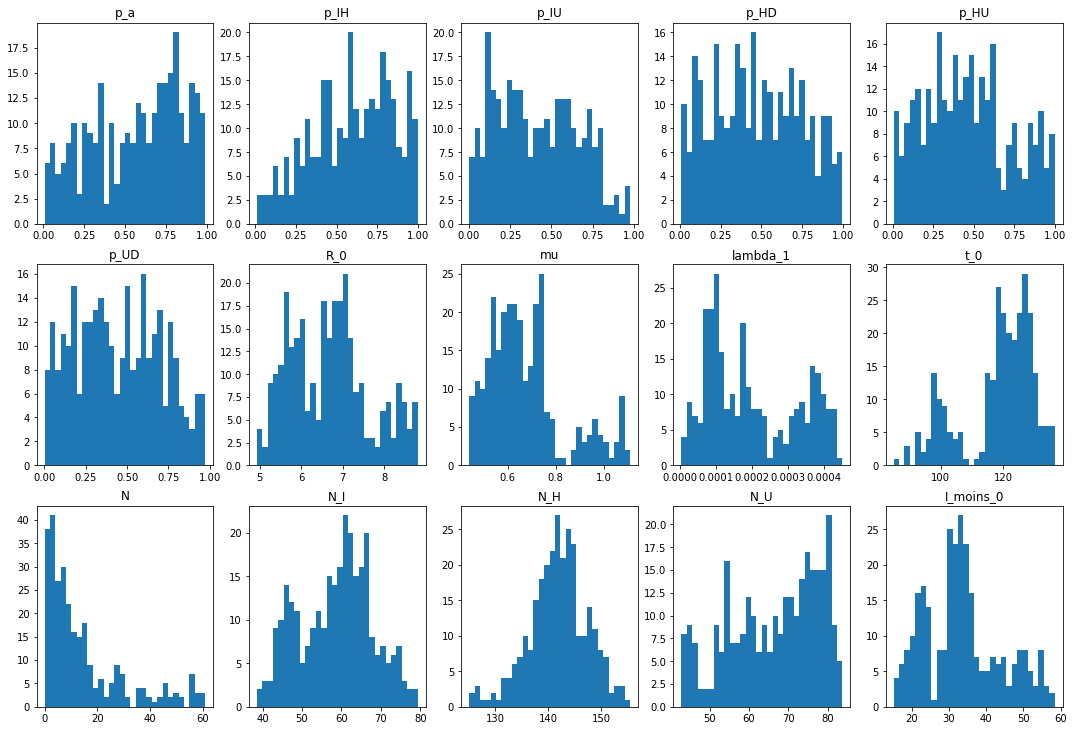

In [69]:
plt.hist(np.array(chain)[:,0], bins= 30)
title = ['H','U', 'R_plus_H', 'D']
indices = ['du 1er ordre', 'totaux']
for j in range(len(chain[0])):
    plt.subplot(3, 5, j+1)
    plt.hist(np.array(chain)[:,j], bins= 30)
    plt.subplots_adjust(left=None, bottom=None, right=2.5, top=2.5, wspace=None, hspace=None)
    plt.title(problem['names'][j])
plt.show()